<a href="https://colab.research.google.com/github/dajebbar/IMDb_text_classification/blob/main/IMDB_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
imdb = pd.read_csv('/content/drive/MyDrive/datasets/imdb.txt')
imdb.head()

,class,clean_text
0,0,slow moving aimless movie distressed drifting ...
1,0,not sure lost flat characters audience nearly ...
2,0,attempting artiness black white clever camera ...
3,0,little music anything speak
4,1,best scene movie gerardo trying find song keep...


In [4]:
# split data
X = imdb['clean_text'].values
y = imdb['class'].values

In [5]:
# train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(type(X_train))

Train set: (596,)
Test set: (150,)
<class 'numpy.ndarray'>


In [6]:
# BoW
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# fit has to happen only on train data
vectorizer.fit(X_train)

# transform
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Applying K-NN

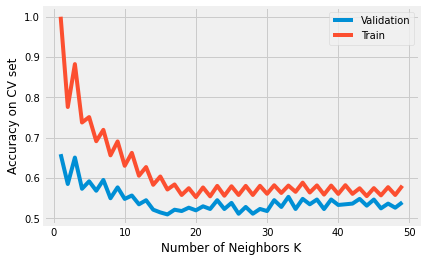

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve

k = list(range(1,50))

model = KNeighborsClassifier()
train_score, val_score = validation_curve(model, X_train_bow, y_train, 'n_neighbors', k, cv=10)

plt.plot(k, val_score.mean(axis=1), label='Validation')
plt.plot(k, train_score.mean(axis=1), label='Train')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy on CV set')
plt.legend()
plt.show()

In [40]:
# GreadSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': k,
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_bow, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [41]:
print(f"Best score: {grid.best_score_ * 100.0}%")
print(f"best parameters: {grid.best_params_}")

Best score: 66.61299435028248%
best parameters: {'metric': 'manhattan', 'n_neighbors': 1}


In [42]:
# save model
model = grid.best_estimator_

print(f"The accuracy of the knn classifier for k = 1 is {model.score(X_test_bow, y_test) * 100.0}%")

The accuracy of the knn classifier for k = 1 is 65.33333333333333%


# Plot Accuracy

In [13]:
#Setup arrays to store training and test accuracies
neighbors = list(range(1,50))
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    #Fit the model
    knn_model.fit(X_train_bow, y_train)
    #Compute accuracy on the training set
    train_accuracy[i] = knn_model.score(X_train_bow, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn_model.score(X_test_bow, y_test) 

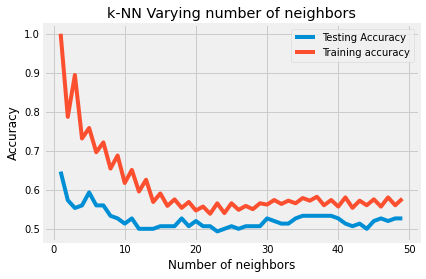

In [15]:
# generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [18]:
#Setup a knn classifier with k neighbors
knn_model = KNeighborsClassifier(n_neighbors=1)
#Fit the model
knn_model.fit(X_train_bow,y_train)

#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn_model.score(X_test_bow,y_test)


0.6466666666666666

# Confusion matrix

In [20]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#let us get the predictions using the classifier we had fit above
y_bow_pred = knn_model.predict(X_test_bow)
confusion_matrix(y_bow_pred, y_test)

array([[63, 38],
       [15, 34]])

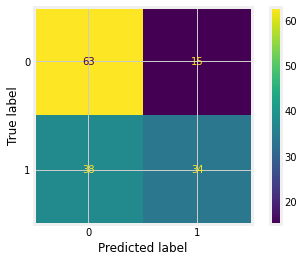

In [21]:
plot_confusion_matrix(knn_model, X_test_bow, y_test)  
plt.show()  

In [24]:
# Confusion matrix can also be obtained using crosstab method of pandas.

pd.crosstab(y_test, y_bow_pred, rownames=['Predicted'], colnames=['Actual'], margins=True)

Actual,0,1,All
Predicted,,,
0,63,15,78
1,38,34,72
All,101,49,150


##Classification Report

Another important report is the Classification report. It is a text summary of the precision, recall, F1 score for each class. Scikit-learn provides facility to calculate Classification report using the classification_report method.

In [25]:
#import classification_report
from sklearn.metrics import classification_report

In [26]:
print(classification_report(y_test,y_bow_pred))

              precision    recall  f1-score   support

           0       0.62      0.81      0.70        78
           1       0.69      0.47      0.56        72

    accuracy                           0.65       150
   macro avg       0.66      0.64      0.63       150
weighted avg       0.66      0.65      0.64       150



## ROC (Reciever Operating Charecteristic) curve

It is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.

An ROC curve demonstrates several things:

  - 1) It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).

  - 2) The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

- 3)The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

- 4) The area under the curve is a measure of test accuracy.

In [27]:
y_bow_pred_proba = knn_model.predict_proba(X_test_bow)[:,1]

In [28]:
from sklearn.metrics import roc_curve

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_bow_pred_proba)

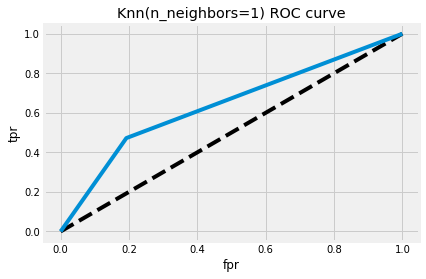

In [30]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=1) ROC curve')
plt.show()

In [32]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_bow_pred_proba)

0.6399572649572649